In [1]:
#imprt the necessary calculations for everything we will use
import datetime
import time
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from netCDF4 import Dataset, num2date, date2num
import numpy as np
from scipy.ndimage import gaussian_filter
from shapely.geometry.polygon import LinearRing
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import xlrd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats import linregress

In [2]:
#blue marble pathway
os.environ["CARTOPY_USER_BACKGROUNDS"] = '/Users/cjmasiel/Desktop/Cartopy/BG/'

In [60]:
#this is the function that creates the map background of the North Atlantic Domain
def create_map_background():
    dataproj = ccrs.PlateCarree()
    fig=plt.figure(figsize=(20, 20))
    ax=plt.subplot(111, projection=dataproj)
    ax.set_extent([-40, -115, 5, 50],ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cfeature.STATES, linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, linewidth=1.0)
    gl = ax.gridlines(color='gray',alpha=0.5,draw_labels=True)
    gl.xlabels_top, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([0,-10, -20,-30, -40,-50, -60,-70, -80,-90,-100,-110])
    gl.ylocator = mticker.FixedLocator([0, 10, 20, 30, 40, 50])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)
    ###############################################################################################
    ax.background_img(name='BM', resolution='high')
    ###############################################################################################
    plt.scatter(-180,-40,alpha = 1.0, color = '#5ebaff', label = 'Tropical Depression')
    plt.scatter(-180,-40,alpha = 1.0, color='#00faf4', label = 'Tropical Storm')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffffcc', label = 'Category 1')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffe775', label = 'Category 2')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffc140', label = 'Category 3')
    plt.scatter(-180,-40,alpha = 1.0, color='#ff8f20', label = 'Category 4')
    plt.scatter(-180,-40,alpha = 1.0, color='#ff6060', label = 'Category 5')
    plt.legend(loc = 'upper left',prop={'size': 16})
    return fig, ax

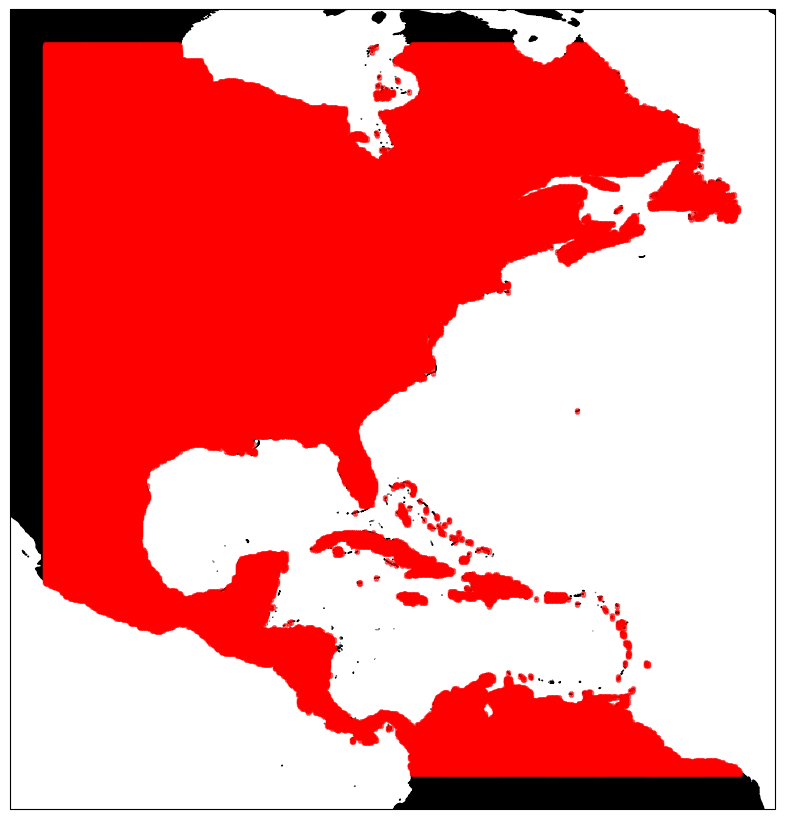

In [4]:
#Here we will create the land sea mask of interest

from IPython import embed
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
import cartopy
from shapely.prepared import prep
import seaborn as sns


land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m')
land_polygons = list(land_10m.geometries())

lats = np.arange(5, 60, 0.1)
lons = np.arange(-105, -50, 0.1)
lon_grid, lat_grid = np.meshgrid(lons, lats)

points = [Point(point) for point in zip(lon_grid.ravel(), lat_grid.ravel())]


land_polygons_prep = [prep(land_polygon) for land_polygon in land_polygons]


land = []
for land_polygon in land_polygons_prep:
    land.extend([tuple(point.coords)[0] for point in filter(land_polygon.covers, points)])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor=sns.xkcd_rgb['black'])

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=ccrs.PlateCarree(),s=12, marker='s', c='red', alpha=0.5, zorder=2)

In [5]:
# Round each element in xs and ys to the nearest decimal
rounded_xs = [round(x, 1) for x in xs]  # Round to one decimal place
rounded_ys = [round(y, 1) for y in ys]  # Round to one decimal place

In [6]:
#so, now that we have the rounded values of xs and ys, we now need to compare the values of the center of storms
#of interest to this list

#next, we parse through the Hurdat dataset to get the years of interest, to start off we will look
#at just one year to make sure it is doing what I think it is 

#This is the list of unique storms I want to consider\n
CODE = []

#Only interested in the years 1980-2023
with open('/Users/cjmasiel/desktop/HURDAT2.txt', 'r') as ds:
    lines_to_read = 0
    for line in ds:
        values = line.split(",")
        if lines_to_read == 0:
            lines_to_read = int(values[2])
            year = float(values[0][4:8])
            for i in range(1979,2023):
                if year == i:
                    code = values[0]
                    CODE.append(code)
        else:
            lines_to_read -=1 

In [7]:
#Now that we have the storms we are interested in looking, we will loop through the same list as before\n",
#However, this time we will have a bunch of logical \n",

VMAX      = []
LAT       = []
LON       = []
CODE_calc = []
PRES      = []
TIME      = []

with open('/Users/cjmasiel/desktop/HURDAT2.txt', 'r') as ds:
    lines_to_read = 0
    for line in ds:
        values = line.split(",")
        if lines_to_read == 0:
            lines_to_read = int(values[2])
            value_lines_to_read = int(values[2]) 
            code = str(values[0])
        else:
            latitude  = float(values[4][:-1])
            longitude = -1 * float(values[5][:-1])
            vmax      = float(values[6])
            nature    = str(values[3])
            time      = str(values[1])
            pressure  = str(values[7])
            for i in CODE:
                if code == i:        #Just looking to see if the AL number is equal to the one in our list\n",
                    if time not in (' 0000', ' 0600', ' 1200', ' 1800'):
                        #print("Do not Consider, " "Storm =", code, "time =", time)
                        continue
                    elif nature in (' TD', ' TS', ' HU'):
                        VMAX.append(vmax)
                        LAT.append(latitude)
                        LON.append(longitude)
                        CODE_calc.append(code)   
                        PRES.append(pressure)
                        TIME.append(time)
            #now we continue parsing through our data set
            lines_to_read -=1 


print("Length of number of Storms appended = ", len(CODE_calc))
print("Length of intensity list = ", len(VMAX))
print("Length of time list = ", len(TIME))

Length of number of Storms appended =  15217
Length of intensity list =  15217
Length of time list =  15217


In [8]:
# Convert rounded_xs and rounded_ys to set for faster lookup
lookup_set = set(zip(rounded_xs, rounded_ys))

# Using zipped values and their indices to check conditions and build lists
indices = [i for i, (lat, lon) in enumerate(zip(LAT, LON)) if (lon, lat) in lookup_set]

LAND_LAT = [LAT[i] for i in indices]
LAND_LON = [LON[i] for i in indices]
LAND_VMAX = [VMAX[i] for i in indices]
LAND_CODE = [CODE_calc[i] for i in indices]
LAND_PRES = [PRES[i] for i in indices]
LAND_TIME = [TIME[i] for i in indices]

print("length of LAND_LAT =", len(LAND_LAT))
print("length of LAND_PRES =", len(LAND_PRES))
print("length of LAND_TIME =", len(LAND_TIME))

length of LAND_LAT = 1453
length of LAND_PRES = 1453
length of LAND_TIME = 1453


In [13]:
unique_code = set(LAND_CODE)

In [46]:
#Now, we are trying to calculate the storms that RI up into landfall

#How are we going to achieve this:
    #First, we figure out the indice in the full length Code_calc, cmax, time, when landfall occurs
    #Next, we look at the the indice prior to this first landfall point, and find its wind speed
    
    #if the indice 5 points ahead of landfall (24 hours prior to the point right at landfall) is also 
    #in the same code, we calculate the 24 hour velocities, if it is above 30 knots, we consider that 
    #an RI event up into landfall. From there, we append this code into a new list: Code_RI
    
    #Then, we plot code RI like we have done for everything else

# Initialize list for RI codes
code_ri = [] 

def RI_up_to_landfall(CODE_calc, VMAX, LAT, LON, target_code, f, g):
    # Convert LAT, LON pairs to a set for efficient lookup
    lookup_set = set(zip(f, g))

    for i, code in enumerate(CODE_calc):
        #print(code)
        if code == target_code:
            # Check if this point is a landfall point
            if (LON[i], LAT[i]) in lookup_set:
                # Check if there are at least 5 points before this index to avoid IndexError
                if i >= 5:
                    vmx_before = VMAX[i - 1]  # Wind speed at the point just before landfall
                    vmx_day_before = VMAX[i - 5]  # Wind speed 24 hours before landfall
                    diff = vmx_before - vmx_day_before
                    #print(diff)
                    if diff >= 30:  # Check if the difference meets RI criteria
                        #print(CODE_calc[i])
                        code_ri.append(CODE_calc[i])
                break  # Assuming you only want the first match for each code

    return code_ri

In [47]:
for item in unique_code:
    return_list = RI_up_to_landfall(CODE_calc, VMAX, LAT, LON, item, rounded_xs, rounded_ys)

In [62]:
print(len(return_list))

22


In [56]:
def plotstorm(x):
    Lat = []
    Long = []
    LatStorm = []
    LongStorm = []
    LatStorm1 = []
    LongStorm1 = []
    Lat1 = []
    Long1 = []
    Lat2 = []
    Long2 = []
    Lat3 = []
    Long3 = []
    Lat4 = []
    Long4 = []
    Lat5 = []
    Long5 = []
    LatSS = []
    LongSS = []
    LatEX = []
    LongEX = []

#Start looping through the text file
    with open('/Users/cjmasiel/desktop/HURDAT2.txt', 'r') as ds:
        lines_to_read = 0
        for line in ds:
            values = line.split(",")
            if lines_to_read == 0:
                lines_to_read = int(values[2])
                code = str(values[0])
            else:
                latitude  = float(values[4][:-1])
                longitude = -1 * float(values[5][:-1])
                vmax      = float(values[6])
                nature    = str(values[3])
                time      = str(values[1])
                if code == x: #and time in (' 0000', ' 0600', ' 1200', ' 1800'):
                    LatStorm1.append(latitude)
                    LongStorm1.append(longitude)
                    if vmax < 34 and nature in (' TD', ' TS', ' HU'):
                        Lat.append(latitude)
                        Long.append(longitude)
                    if 34 <= vmax < 63 and nature in (' TD', ' TS', ' HU'):
                        LatStorm.append(latitude)
                        LongStorm.append(longitude)
                    if 63 < vmax <= 83 and nature in (' TD', ' TS', ' HU'):
                        Lat1.append(latitude)
                        Long1.append(longitude)
                    if 83 < vmax <= 95 and nature in (' TD', ' TS', ' HU'):
                        Lat2.append(latitude)
                        Long2.append(longitude)
                    if 95 < vmax <= 112 and nature in (' TD', ' TS', ' HU'):
                        Lat3.append(latitude)
                        Long3.append(longitude)
                    if 112 < vmax <= 136 and nature in (' TD', ' TS', ' HU'):
                        Lat4.append(latitude)
                        Long4.append(longitude)
                    if vmax > 136 and nature in (' TD', ' TS', ' HU'):
                        Lat5.append(latitude)
                        Long5.append(longitude)
                    if nature in (' SS'):
                        LatSS.append(latitude)
                        LongSS.append(longitude)
                    if nature in (' EX',' LO',' WV',' SD',' DB'):
                        LatEX.append(latitude)
                        LongEX.append(longitude)  
                #After going through all these logical loops, now we read back one
                lines_to_read -=1 

    #Below is the plotting code \n",
    plt.plot(LongStorm1, LatStorm1, alpha = 1.0, color='grey', linewidth=1,zorder=1)
    plt.scatter(Long, Lat, color = '#5ebaff',s=50, label = 'Tropical Depression',zorder=2)
    plt.scatter(LongStorm,LatStorm, color='#00faf4',s=50, label = 'Tropical Storm',zorder=3)
    plt.scatter(Long1,Lat1,alpha = 1.0,s=50, color='#ffffcc', label = 'Category 1',zorder=4)
    plt.scatter(Long2,Lat2,alpha = 1.0, s=50,color='#ffe775', label = 'Category 2',zorder=5)
    plt.scatter(Long3,Lat3,alpha = 1.0,s=50, color='#ffc140', label = 'Category 3',zorder=6)
    plt.scatter(Long4,Lat4,alpha = 1.0,s=50, color='#ff8f20', label = 'Category 4',zorder=7)
    plt.scatter(Long5,Lat5,alpha = 1.0,s=50, color='#ff6060', label = 'Category 5',zorder=8)
    plt.scatter(LongEX,LatEX,alpha = 1.0,s=50, color='#5ebaff', marker  = 'v', label = 'Extra-Tropical',zorder=9)
    plt.scatter(LongSS,LatSS,alpha = 1.0,s=50, color='#00faf4', marker = 'v', label = 'Sub-Tropical Storm',zorder=10)

    plt.title(f'Storms That Rapdily Intensify (RI) Up To Landfall (1980-2022)', loc = 'left',fontsize = 20 )
    plt.title('Product by: Cameron Masiello', loc = 'right', fontsize = 20)

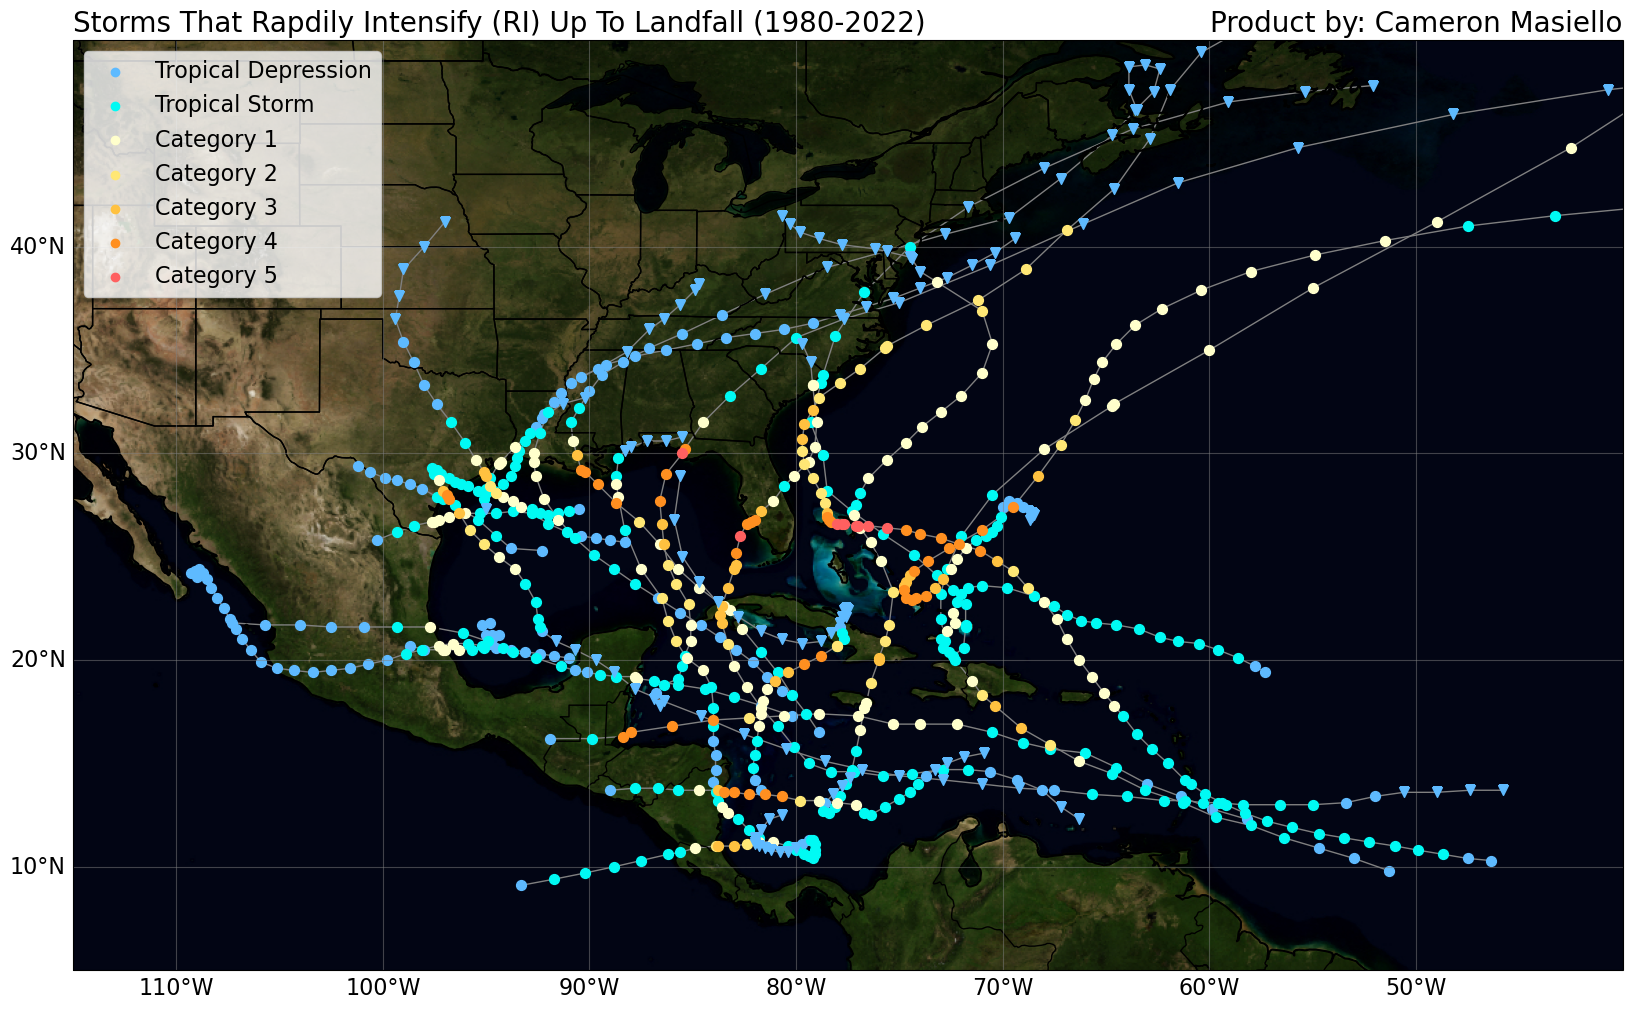

In [61]:
fig, ax = create_map_background()

for item in return_list:
    #print(item)
    plotstorm(item)